In [513]:
###IMPORT NECESSARY MODULES

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy import stats
from scipy.stats import zscore
from scipy.stats import gaussian_kde
from scipy.stats import skew, kurtosis
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox


#Problem A1. 

Download daily data for any two stock market indices over any available sample period of your choice
from (Yahoo Finance). Your dataset must contain at least 252 observations (there is no upper limit on the
sample size), and the selected indices and sample period must remain confidential. Using Python only,
compute and report descriptive statistics for each index (at a minimum: mean, median, variance, standard de-
viation, skewness, and kurtosis) and compute the correlation coefficient between the two index return series.
Finally, compare and interpret the results, commenting on differences in central tendency, dispersion, tail behavior,
and co-movement between the two indices

In [612]:
### Download data from YF
tickers = ["^DJI", "^RUT"]

data = yf.download(tickers=tickers, period="2y", interval="1d", progress=False)

print(f"Number of observations: {len(data)}")
print(data.tail())

# Access individual indices
dow_close = data['Close']['^DJI']
russell_close = data['Close']['^RUT']

Number of observations: 502
Price              Close                       High               \
Ticker              ^DJI         ^RUT          ^DJI         ^RUT   
Date                                                               
2026-01-26  49412.398438  2659.669922  49488.808594  2684.989990   
2026-01-27  49003.410156  2666.699951  49157.800781  2668.560059   
2026-01-28  49015.601562  2653.550049  49150.339844  2685.860107   
2026-01-29  49071.558594  2654.780029  49292.808594  2665.060059   
2026-01-30  48892.468750  2613.739990  49047.679688  2648.270020   

Price                Low                       Open                  Volume  \
Ticker              ^DJI         ^RUT          ^DJI         ^RUT       ^DJI   
Date                                                                          
2026-01-26  49137.648438  2657.419922  49137.648438  2672.370117  454370000   
2026-01-27  48862.519531  2650.639893  49103.578125  2659.929932  533780000   
2026-01-28  48901.488281  2647.6

In [582]:
### Get daily returns and adjust to a percentage
dow_daily_returns = dow_close.pct_change()*100
russell_daily_returns = russell_close.pct_change()*100

### Print Summary Stats of data
print('Dow Summary: ', dow_daily_returns.describe())
print('\nRussell Summary: ', russell_daily_returns.describe())

### Indicates if the data is skewed right or left
print('\n\nDow Skew: ', dow_daily_returns.skew())
print('Russell Skew: ', russell_daily_returns.skew())

### Zero Kurtosis (Mesokurtic): The distribution has the same tail heaviness as a normal distribution (baseline is often zero excess kurtosis). 
### Positive Kurtosis (Leptokurtic): The distribution has heavier tails and a sharper, more peaked center (more outliers).
### Negative Kurtosis (Platykurtic): The distribution has lighter tails and a flatter peak (fewer outliers). 
print('\nDow Kurtosis: ', dow_daily_returns.kurtosis())
print('Russell Kurtosis: ', russell_daily_returns.kurtosis(),'\n\n')


returns_df = pd.DataFrame({
    'Dow': dow_daily_returns,
    'Russell': russell_daily_returns
})

# Calculate correlation matrix
correlation_matrix = returns_df.corr()

print("Correlation Matrix:")
print(correlation_matrix)

Dow Summary:  count    501.000000
mean       0.053613
std        0.906063
min       -5.502575
25%       -0.377181
50%        0.083771
75%        0.551525
max        7.870402
Name: ^DJI, dtype: float64

Russell Summary:  count    501.000000
mean       0.068153
std        1.373022
min       -6.591013
25%       -0.714942
50%        0.104243
75%        0.899695
max        8.658443
Name: ^RUT, dtype: float64


Dow Skew:  0.5996674278333699
Russell Skew:  0.20455920744046763

Dow Kurtosis:  14.330121517466782
Russell Kurtosis:  4.566668250187899 


Correlation Matrix:
              Dow   Russell
Dow      1.000000  0.836207
Russell  0.836207  1.000000


The summary statistics show some important differences in how these indices behave. The Russell has slightly higher average returns (0.068% vs 0.054%) but comes with significantly more volatility (1.37% vs 0.91%), so the risk-adjusted performance is pretty similar between them. Both have positive skewness, with the Dow showing more pronounced asymmetry (0.60 vs 0.20) - meaning extreme gains stretch further than extreme losses. This is favorable from a risk perspective since it suggests upside surprises outweigh catastrophic downside scenarios, though the minimum values (-6.59% Russell, -5.50% Dow) remind us that fat left tails definitely still exist.


The kurtosis numbers are really striking here: the Dow's 14.33 absolutely dominates the Russell's 4.57, telling us the Dow experiences extreme events - both up and down - way more frequently than normal distributions would predict. This fat-tail behavior is critical for options pricing and risk management because standard models assuming normality will consistently underestimate how often large moves actually happen. The strong 0.84 correlation confirms these indices generally move together, though their different kurtosis profiles suggest the Dow might be more prone to sudden jumps during stress periods. For my Russell reconstitution research, these statistics validate that jump risk and tail events are real factors that options markets might systematically misprice around discrete events like index rebalancing.

In [584]:
###Calculate log returns and print
dow_log_returns = np.log(dow_close / dow_close.shift(1))*100
print((dow_log_returns).describe())

russell_log_returns = np.log(russell_close / russell_close.shift(1))*100
print('\n\n\n', (russell_log_returns).describe())


count    501.000000
mean       0.049519
std        0.903682
min       -5.659760
25%       -0.377895
50%        0.083736
75%        0.550009
max        7.576034
Name: ^DJI, dtype: float64



 count    501.000000
mean       0.058746
std        1.371006
min       -6.818262
25%       -0.717510
50%        0.104189
75%        0.895672
max        8.303923
Name: ^RUT, dtype: float64


In [614]:
### Calculate returns moving average (dollar values)
dow_ma_20_log = dow_log_returns.rolling(window=20).mean()
russell_ma_20_log = russell_log_returns.rolling(window=20).mean()

dow_ma_20 = dow_close.rolling(window=20).mean()
russell_ma_20 = russell_close.rolling(window=20).mean()

print('DOW: ', dow_ma_20)
print('\n\n\nRussell: ', russell_ma_20)

DOW:  Date
2024-01-31             NaN
2024-02-01             NaN
2024-02-02             NaN
2024-02-05             NaN
2024-02-06             NaN
                  ...     
2026-01-26    49019.283984
2026-01-27    49033.906055
2026-01-28    49061.589648
2026-01-29    49096.814648
2026-01-30    49138.273633
Name: ^DJI, Length: 502, dtype: float64



Russell:  Date
2024-01-31            NaN
2024-02-01            NaN
2024-02-02            NaN
2024-02-05            NaN
2024-02-06            NaN
                 ...     
2026-01-26    2607.155481
2026-01-27    2613.772974
2026-01-28    2620.460474
2026-01-29    2628.169971
2026-01-30    2634.761475
Name: ^RUT, Length: 502, dtype: float64


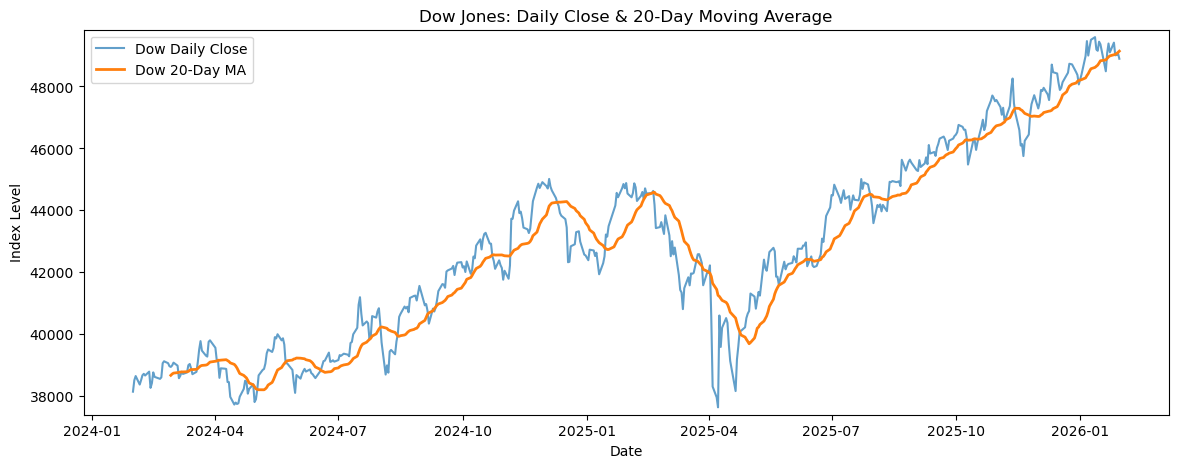

In [586]:
###Plot returns

#To help scale the chart
y_min = min(dow_close.min(), dow_ma_20.min())
y_max = max(dow_close.max(), dow_ma_20.max())
padding = 0.02 * (y_max - y_min)

plt.figure(figsize=(14, 5))
plt.plot(dow_close.index, dow_close, label="Dow Daily Close", alpha=0.7)
plt.plot(dow_ma_20.index, dow_ma_20, label="Dow 20-Day MA", linewidth=2)

plt.ylim(y_min - padding, y_max + padding)

plt.title("Dow Jones: Daily Close & 20-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.show()



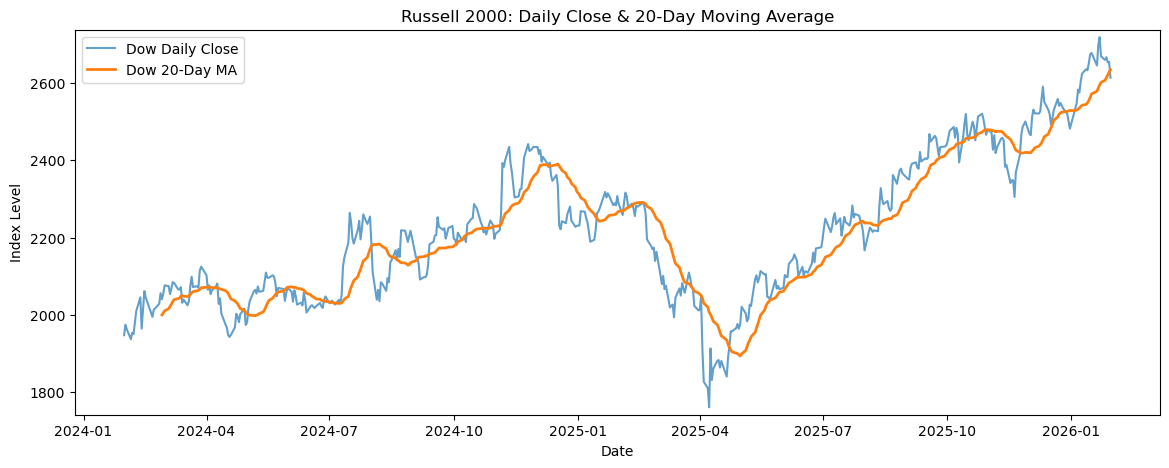

In [587]:
y_min = min(russell_close.min(), russell_ma_20.min())
y_max = max(russell_close.max(), russell_ma_20.max())

padding = 0.02 * (y_max - y_min)

plt.figure(figsize=(14, 5))
plt.plot(russell_close.index, russell_close, label="Dow Daily Close", alpha=0.7)
plt.plot(russell_ma_20.index, russell_ma_20, label="Dow 20-Day MA", linewidth=2)

plt.ylim(y_min - padding, y_max + padding)

plt.title("Russell 2000: Daily Close & 20-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.show()

One MA strategy is to buy when price breaks up through the moving average and sell when it breaks below. The moving average acts as a less noisy representation of the stock's value, with price oscillating above and below it. These oscillations happen naturally in markets, and using technical indicators like moving averages, traders can potentially take advantage of mean reversion and trend continuation patterns.

The strategy of just blindly following a moving average as a buy/sell indicator isn't optimal though. There are plenty of times when price chops above and below the MA in sideways markets, and you'd get killed on transaction costs from repeated whipsaw trades that yield no profit. However, there are stretches where this strategy actually works really well. For example, after the crash in April 2025, both the Russell and Dow followed the 20-day MA almost all the way up to new highs - that's exactly the type of trending environment where MA strategies shine.

It seems like the 20-day MA by itself is probably a break-even strategy at best once you factor in transaction costs and whipsaws. But if you pair it with other momentum indicators - like volume confirmation, RSI to filter out overbought/oversold chops, or volatility measures to identify trending vs ranging regimes - it could actually prove useful as part of a broader system. The key is using the MA as one signal among several rather than treating it as a standalone holy grail.

#Problem A3.


For each of the two assets, compute both simple returns and log returns, and then visualize their empiri-
cal distributions using: (i) a histogram (with an appropriate number of bins), (ii) a kernel density estimate
(KDE) plot, and (iii) a normal Q–Q plot. Based on these figures, comment on any departures from a bell-shaped
(normal) distribution, including evidence of skewness, fat tails (leptokurtosis), or outliers. Next, compare the
distributions of simple vs. log returns for each asset, and then compare these distributional features across the
two assets (e.g., differences in tail thickness, asymmetry, and overall dispersion). Your Python output (plots
and any relevant numerical summaries) and your interpretation/comments must be included in the main
PDF submission.

In [620]:
df = pd.DataFrame(russell_close)
df2 = pd.DataFrame(dow_close)

df3 = [df, df2]

In [622]:
simple_ret_RUT = df3[0].pct_change().dropna()
log_ret_RUT = np.log(df3[0] / df3[0].shift(1)).dropna()

simple_ret_DJI = df3[1].pct_change().dropna()
log_ret_DJI = np.log(df3[1]/ df3[1].shift(1)).dropna()

In [624]:
simple_returns = [simple_ret_RUT] + [simple_ret_DJI]
log_returns = [log_ret_RUT] + [log_ret_DJI]

In [626]:
def fd_bins(x):
    x = np.asarray(x)
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    if iqr == 0:
        return 30
    bw = 2 * iqr * (len(x) ** (-1/3))
    return max(10, int((x.max() - x.min()) / bw))



In [628]:
def plot_distributions(x, title):
    x = x.dropna()

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # (i) Histogram
    bins = fd_bins(x.values)
    axes[0].hist(x, bins=bins, density=True, alpha=0.8)
    axes[0].set_title(f"{title} – Histogram")
    axes[0].set_xlabel("Return")
    axes[0].set_ylabel("Density")

    # (ii) KDE
    kde = gaussian_kde(x.values)
    grid = np.linspace(x.min(), x.max(), 400)
    axes[1].plot(grid, kde(grid), linewidth=2)
    axes[1].set_title(f"{title} – KDE")
    axes[1].set_xlabel("Return")

    # (iii) Normal Q–Q
    z = zscore(x.values, nan_policy='omit')

    # Q–Q plot
    sm.qqplot(z, line="45", ax=axes[2])
    axes[2].set_title(f"{title} – Normal Q–Q (Standardized)")

    plt.tight_layout()
    plt.show()


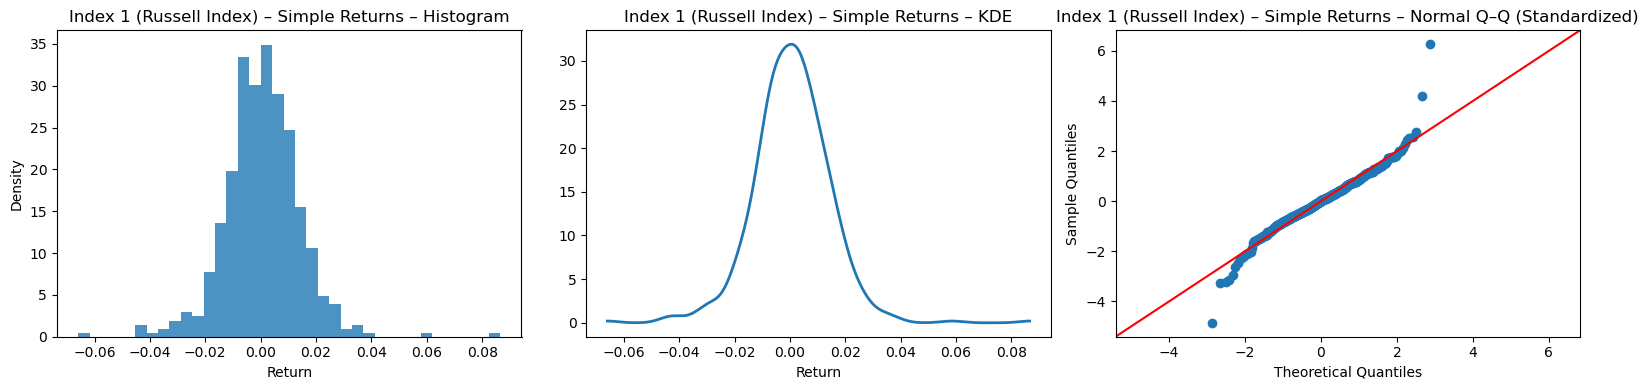

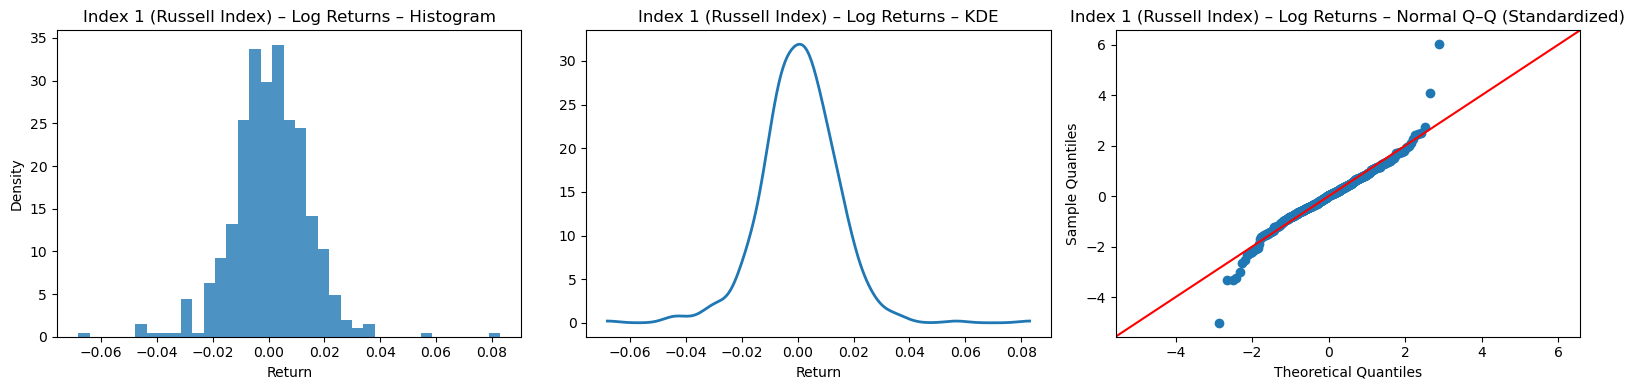

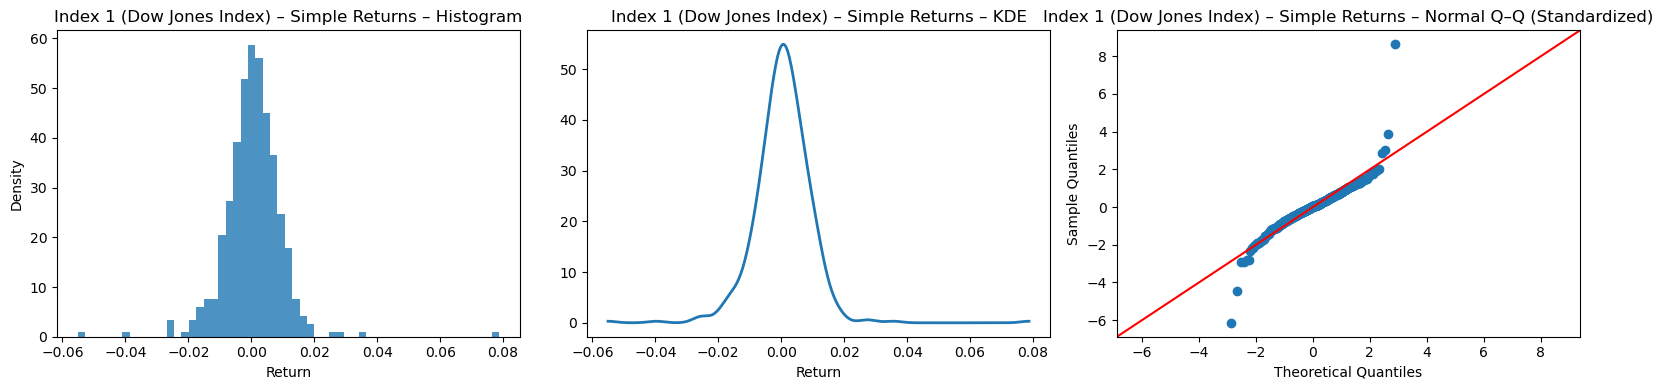

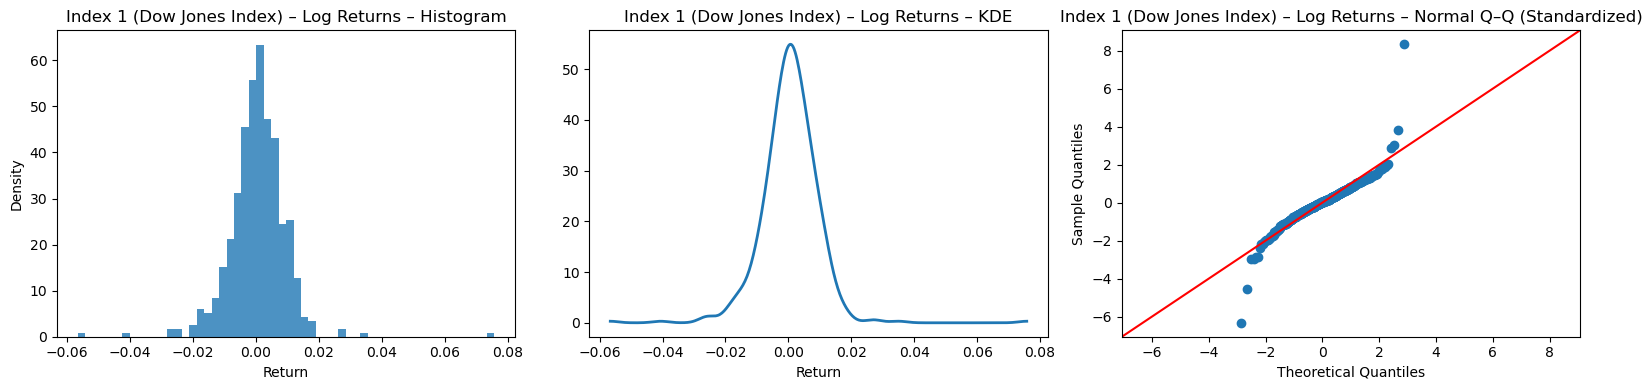

In [630]:
plot_distributions(simple_returns[0]['^RUT'], "Index 1 (Russell Index) – Simple Returns")
plot_distributions(log_returns[0]['^RUT'], "Index 1 (Russell Index) – Log Returns")

plot_distributions(simple_returns[1]['^DJI'], "Index 1 (Dow Jones Index) – Simple Returns")
plot_distributions(log_returns[1]['^DJI'], "Index 1 (Dow Jones Index) – Log Returns")

The comparison between simple and log returns shows they're basically identical in terms of distributional properties - same histogram shapes, KDE curves, and Q-Q patterns. Both indices have positive skewness (Dow: 0.60, Russell: 0.20), which means the extreme gains extend further into the right tail than extreme losses do into the left tail. This is actually good for risk since it suggests more upside surprise potential than catastrophic downside, though we still see some severe negative moves (Russell: -6.59%, Dow: -5.50%). The fat tails are really the dominant feature here, showing that markets experience occasional large shocks in both directions that go way beyond what standard volatility measures would predict. The Dow's more extreme kurtosis probably reflects crisis dynamics or how its large-cap concentration led to more dramatic swings during turbulent periods.

PART B: Factor Models. (10 pts.)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


Problem B1.


Download the 10 Industry Portfolios data from the Kenneth R. French Data Library (Online Data Library), as
well as the corresponding factor data and the risk-free rate (you must download all factor files necessary for
this assignment). Your sample must contain at least 252 observations (there is no upper limit on the sample
size). From the 10 industry portfolios, select any two portfolios and compute descriptive statistics for their
(excess) return series, including mean, variance, standard deviation, skewness, and kurtosis. Finally, com-
pare and interpret the results, commenting on differences in central tendency, dispersion, and tail behavior across
the two selected industry portfolios.

In [370]:
ff = pd.read_csv("F-F_Research_Data_Factors.csv") #Read in the csv files
ind = pd.read_csv("10_Industry_Portfolios.csv")
ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m') #Change to date time
ind['Date'] = pd.to_datetime(ind['Date'], format='%Y%m')
df = ind.join(ff["RF"], how="inner") #Merge the two into df
ff.set_index('Date') #Set indexes as their date column to make future merges easier
df.set_index('Date')

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,RF
Date,,,,,,,,,,,
2002-01-01,1.46,6.20,2.49,-4.83,3.58,-11.58,5.75,-3.50,-2.40,3.21,0.14
2002-02-01,1.34,0.32,0.49,1.53,-11.72,-11.89,-1.87,-7.63,0.22,-0.20,0.13
2002-03-01,7.99,7.74,9.81,14.48,10.48,5.02,8.55,6.75,7.92,6.45,0.13
2002-04-01,5.25,4.24,1.40,1.11,-6.57,-6.95,4.67,-6.39,0.43,3.72,0.15
2002-05-01,1.08,-2.15,-2.37,-5.43,-6.86,-5.62,1.60,-4.26,-3.71,-0.05,0.14
...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01,2.65,6.02,6.59,3.94,3.90,9.16,5.92,9.12,0.25,7.15,0.38
2025-09-01,-3.35,1.17,1.14,2.77,5.71,1.46,0.31,6.69,3.83,0.46,0.33
2025-10-01,-5.70,-6.90,-0.51,1.13,5.07,1.28,-5.77,6.13,0.26,-4.16,0.37


In [542]:
p1 = "Manuf" #Manufacturing
p2 = "HiTec" #HighTech

excess_1 = df[p1] - df["RF"] #Excess returns
excess_2 = df[p2] - df["RF"]

#print(len(excess_1), len(excess_2)) #Just for checking purposes


In [533]:
def desc(x):
    return pd.Series({"Mean": x.mean(), "Variance": x.var(ddof=1), "Std Dev": x.std(ddof=1), 
                      "Skewness": skew(x, bias=False), "Excess Kurtosis": kurtosis(x, fisher=True, bias=False)}) 
    # Bias = False, then the calculations are corrected for statistical bias.
    # If True, Fisher's definition is used (normal ==> 0.0)

stats = pd.DataFrame({p1: desc(excess_1), p2: desc(excess_2)}) #

print(stats)


                     Manuf      HiTec
Mean              0.969132   0.970174
Variance         44.687404  50.370644
Std Dev           6.684864   7.097228
Skewness         -0.215433   0.119424
Excess Kurtosis   1.879470   1.167992


The Manufacturing and HiTech portfolios exhibit very similar mean monthly excess returns, with HiTech only marginally higher. However, HiTech shows greater variance and standard deviation, indicating higher volatility relative to Manufacturing.

Skewness differs across the two portfolios. Manufacturing displays slightly negative skewness (−0.22), suggesting marginally greater downside tail risk, while HiTech’s skewness is close to zero, indicating a more symmetric return distribution.

Both portfolios exhibit positive excess kurtosis, implying fat-tailed return distributions relative to the normal distribution. Manufacturing shows higher excess kurtosis than HiTech, suggesting a greater likelihood of extreme return realizations.


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Problem B2.

    
For each of the two selected industry portfolios, plot the empirical distribution of returns using (i) a histogram
and (ii) a kernel density estimate (KDE) curve. Based on these plots, comment on the overall shape of each
distribution (e.g., symmetry vs. skewness, presence of fat tails, outliers, and how closely it resembles a bell-shaped
curve). Finally, compare the two portfolios by discussing differences in location, spread, tail thickness, and any
visible asymmetry in their return distributions.

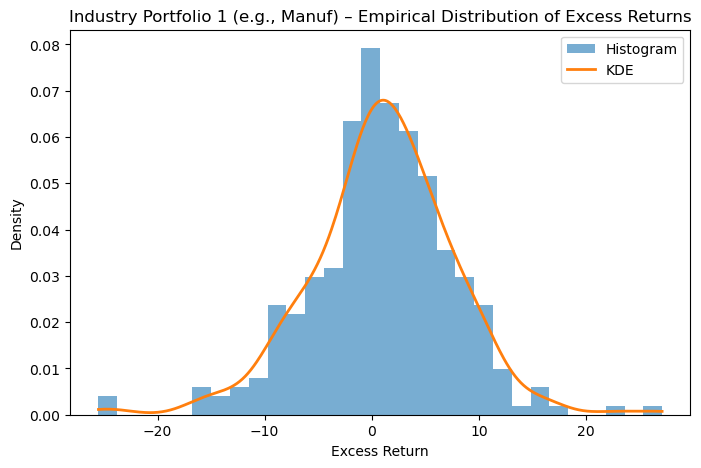

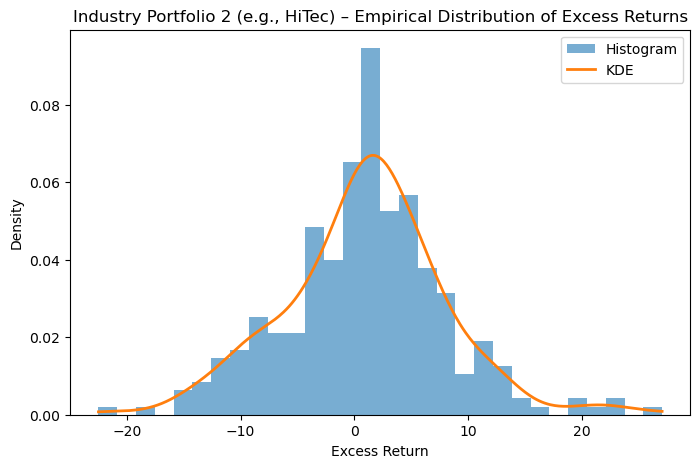

In [545]:
def plot_hist_kde(x, label):
    x = x.dropna()

    plt.figure(figsize=(8, 5))

    # Histogram (density-scaled)
    plt.hist(x, bins=30, density=True, alpha=0.6, label="Histogram")

    # KDE
    kde = gaussian_kde(x)
    grid = np.linspace(x.min(), x.max(), 400)
    plt.plot(grid, kde(grid), linewidth=2, label="KDE")

    plt.title(f"{label} – Empirical Distribution of Excess Returns")
    plt.xlabel("Excess Return")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


plot_hist_kde(excess_1, f"Industry Portfolio 1 (e.g., {p1})")
plot_hist_kde(excess_2, f"Industry Portfolio 2 (e.g., {p2})")


Both industry portfolios have roughly bell-shaped return distributions, but neither follows a normal distribution particularly well. The histograms and KDEs show noticeably heavy tails, which is consistent with the positive excess kurtosis observed for both portfolios.

Manufacturing shows a slightly heavier left tail, in line with its negative skewness, suggesting somewhat greater downside risk. HiTech, by comparison, looks more symmetric, with returns more evenly distributed around the mean.

Differences in volatility are also clear from the plots. The HiTech portfolio has a wider spread and more extreme observations, which matches its higher variance and standard deviation.

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


Problem B3.

Estimate the one-factor Fama–French model for each of the two selected industry portfolios (i.e., run two
separate regressions using the market factor and the risk-free rate from the Kenneth R. French data). Report
the key regression output for each portfolio and interpret the results, focusing on goodness-of-fit (e.g., R2 / ad-
justed R2), statistical significance (t-stats / p-values), and the economic meaning of the estimated coefficients
(intercept and factor loading). Compare the two portfolios and comment on differences in systematic risk exposure
and model fit.

In [380]:
mkt = ff["Mkt-RF"]   # market excess return
Y1 = excess_1
X = sm.add_constant(mkt.loc[Y1.index])  # align dates + add intercept

model_1 = sm.OLS(Y1, X).fit() # Ordinary Least Squares
print(model_1.summary())

Y2 = excess_2
X = sm.add_constant(mkt.loc[Y2.index]) # align dates + add intercept

model_2 = sm.OLS(Y2, X).fit()
print(model_2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     1031.
Date:                Thu, 05 Feb 2026   Prob (F-statistic):           7.58e-97
Time:                        14:46:46   Log-Likelihood:                -735.39
No. Observations:                 288   AIC:                             1475.
Df Residuals:                     286   BIC:                             1482.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0609      0.187     -0.326      0.7

Both portfolios show strong, statistically significant exposure to the market factor. Their betas are greater than one, at approximately 1.34 and 1.38, respectively. The intercepts are not statistically different from zero, as indicated by both the p-values and the confidence intervals. The CAPM is fairly descriptive of returns, with adjusted R² values above 0.7, implying that the model explains roughly 75% of the variation in excess returns.

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

Problem B4.


Estimate the three-factor Fama–French model and the four-factor Fama–French–Carhart model for each
of the two selected industry portfolios (i.e., estimate four regressions in total: 2 portfolios × 2 models). Using the
corresponding Kenneth R. French factors and the risk-free rate, report the main regression output and interpret
the results, focusing on goodness-of-fit (e.g., R2 / adjusted R2), statistical significance of the coefficients (t-
stats / p-values), and the economic meaning of the estimated intercept and factor loadings (market, size, value,
and momentum). Finally, compare (i) the three-factor vs. four-factor results for each portfolio and (ii) the factor
exposures across the two portfolios, commenting on what the estimates imply about systematic risk sources and
whether adding momentum materially improves the fit.

In [551]:
mom = pd.read_csv("F-F_Momentum_Factor.csv")

drop = ["Unnamed: 3", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10", "Unnamed: 11"] #Weird colums came in
mom = mom.drop(columns=drop, errors="ignore")

mom['Date'] = (mom['Date'].astype(str).str.replace(r'[^0-9]', '', regex=True).str[:6]) # keep YYYYMM only #Extra 1 was added at the end of cells so drop the 1

mom['Date'] = pd.to_datetime(mom['Date'], format='%Y%m') # Convert to Date Time
mom = mom.set_index('Date')

#Convert to data frame then set index to 'Date' column for .join() function
excess_1 = excess_1.to_frame("Excess") 
excess_1["Date"] = ff.index
excess_1 = excess_1.set_index("Date")

excess_2 = excess_2.to_frame("Excess")
excess_2["Date"] = ff.index
excess_2 = excess_2.set_index("Date")

mom['UMD'] = mom['UMD'] / 100


In [399]:
# Combine factors
factors_3 = ff[["Mkt-RF", "SMB", "HML"]]
factors_4 = factors_3.join(mom["UMD"], how="inner")

# Align everything
df1_3 = excess_1.join(factors_3, how="inner")
df1_4 = excess_1.join(factors_4, how="inner")

df2_3 = excess_2.join(factors_3, how="inner")
df2_4 = excess_2.join(factors_4, how="inner")


In [401]:
# Portfolio 1
model1_ff3 = run_reg(df1_3)
model1_ff4 = run_reg(df1_4)

# Portfolio 2
model2_ff3 = run_reg(df2_3)
model2_ff4 = run_reg(df2_4)

print(model1_ff3.summary())
print(model1_ff4.summary())
print(model2_ff3.summary())
print(model2_ff4.summary())


                            OLS Regression Results                            
Dep. Variable:                 Excess   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     1032.
Date:                Thu, 05 Feb 2026   Prob (F-statistic):          2.37e-152
Time:                        14:49:16   Log-Likelihood:                -598.67
No. Observations:                 288   AIC:                             1205.
Df Residuals:                     284   BIC:                             1220.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0264      0.117      0.227      0.8

For the first portfolio, the Fama–French three-factor model explains a large share of return variation, with an adjusted R^2 of about 0.92. The market, size, and value factors are all positive and highly statistically significant. The intercept is small and not statistically different from zero, suggesting no abnormal performance after controlling for these risk factors.

Adding the momentum factor does not materially change the results. The coefficients on the market, SMB, and HML factors remain essentially unchanged, and the momentum coefficient is not statistically significant. The adjusted R^2 stays the same, indicating that momentum does not provide additional explanatory power for this portfolio.

For the second portfolio, the three-factor model explains slightly less variation, with an adjusted R^2 around 0.85, but still performs well overall. The portfolio shows strong positive exposure to the market and size factors, while the value loading is negative and statistically significant, indicating growth-oriented behavior. The intercept is again not statistically significant.

As with the first portfolio, adding momentum does not improve model fit. The momentum coefficient is statistically insignificant, and the adjusted R^2 remains unchanged. In both cases, residual diagnostics indicate non-normality and fat tails.

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

Problem B5.


Estimate the five-factor Fama–French model for each of the two selected industry portfolios (i.e., estimate two
regressions in total). Using the corresponding Kenneth R. French five-factor data and the risk-free rate, report the
key regression output for each portfolio and interpret the results, focusing on goodness-of-fit (e.g., R2 / adjusted
R2), statistical significance of the estimated coefficients (t-stats / p-values), and the economic meaning of the
intercept and factor loadings (market, size, value, profitability, and investment). Finally, compare the two portfolios
and comment on differences in factor exposures and model fit, and discuss whether the intercept suggests abnormal
performance after controlling for the five systematic factors.

In [446]:
ff5 = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv")
ff5.rename(columns={'Unnamed: 0': 'Date'}, inplace=True) #Fix naming
ff5.index = pd.to_datetime(ff5['Date'], format="%Y%m") #Fix dates


,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
2002-01-01,1.46,6.20,2.49,-4.83,3.58,-11.58,5.75,-3.50,-2.40,3.21
2002-02-01,1.34,0.32,0.49,1.53,-11.72,-11.89,-1.87,-7.63,0.22,-0.20
2002-03-01,7.99,7.74,9.81,14.48,10.48,5.02,8.55,6.75,7.92,6.45
2002-04-01,5.25,4.24,1.40,1.11,-6.57,-6.95,4.67,-6.39,0.43,3.72
2002-05-01,1.08,-2.15,-2.37,-5.43,-6.86,-5.62,1.60,-4.26,-3.71,-0.05
...,...,...,...,...,...,...,...,...,...,...
2025-08-01,2.65,6.02,6.59,3.94,3.90,9.16,5.92,9.12,0.25,7.15
2025-09-01,-3.35,1.17,1.14,2.77,5.71,1.46,0.31,6.69,3.83,0.46
2025-10-01,-5.70,-6.90,-0.51,1.13,5.07,1.28,-5.77,6.13,0.26,-4.16


In [558]:
# Industry
p1 = "Manuf" 
p2 = "HiTec" 

df_ff5 = ind.set_index('Date').join(ff5, how="inner")
df_ff5.pop('Date') #Get rid of date (bad programming I know. It got messed up earlier.)
excess_1 = df[p1] - df["RF"]
excess_2 = df[p2] - df["RF"]

def run_ff5(y, X):
    Xc = sm.add_constant(X.loc[y.index])
    return sm.OLS(y, Xc).fit()

model_1 = run_ff5(excess_1, X)
model_2 = run_ff5(excess_2, X)

print(model_1.summary())
print(model_2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     1031.
Date:                Thu, 05 Feb 2026   Prob (F-statistic):           7.58e-97
Time:                        18:19:44   Log-Likelihood:                -735.39
No. Observations:                 288   AIC:                             1475.
Df Residuals:                     286   BIC:                             1482.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0609      0.187     -0.326      0.7

Comparing the two portfolios, both exhibit strong exposure to the market factor, with estimated betas greater than one. The second portfolio has a slightly higher market beta (about 1.38 versus 1.34), indicating marginally greater sensitivity to market movements.

In terms of model fit, the first portfolio is better explained by the factor model, with an R^2 of approximately 0.78 compared to about 0.74 for the second portfolio. This indicates that systematic risk factors account for a larger share of return variation in the first portfolio, while the second portfolio has relatively more idiosyncratic variation not captured by the model.

Finally, the intercepts for both portfolios are not statistically different from zero, as evidenced by high p-values and confidence intervals that include zero. This implies that there is no evidence of abnormal performance after controlling for the systematic risk factors. Overall, differences in returns across the two portfolios appear to be driven by differences in factor exposures rather than unexplained alpha.

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

Problem C1.


Pick two additional stocks from (Yahoo Finance) and download daily price data containing at least 252 observations
per stock (there is no upper limit on the sample size); your dataset should remain confidential. Using Python only,
compute and plot (on the same figure) any two historical volatility measures (e.g., close-to-close volatility and an
OHLC-based estimator such as Parkinson, Garman–Klass, or Rogers–Satchell), and then report descriptive statistics
for both volatility series (e.g., mean, median, standard deviation, min/max, and selected quantiles). Finally,
interpret both the plot and the descriptive statistics from an investor’s standpoint, commenting on differences in
volatility levels, variability, and potential implications for risk management and portfolio decisions.

In [581]:
tickers = ["IONQ", "JNJ"]

data = yf.download(
    tickers,
    start="2022-01-01",   # > 252 obs
    progress=False
)

# Extract OHLC
ohlc = {
    t: data.xs(t, level=1, axis=1)[["Open", "High", "Low", "Close"]].dropna()
    for t in tickers
}


In [564]:
def close_to_close_vol(df):
    log_ret = np.log(df["Close"] / df["Close"].shift(1))
    return np.sqrt(252) * log_ret.abs()

def parkinson_vol(df):
    hl = np.log(df["High"] / df["Low"])
    return np.sqrt(252) * np.sqrt((1 / (4 * np.log(2))) * hl**2)

vol = {}

for t in tickers:
    vol[t] = pd.DataFrame({
        "CtC": close_to_close_vol(ohlc[t]),
        "Parkinson": parkinson_vol(ohlc[t])
    }).dropna()


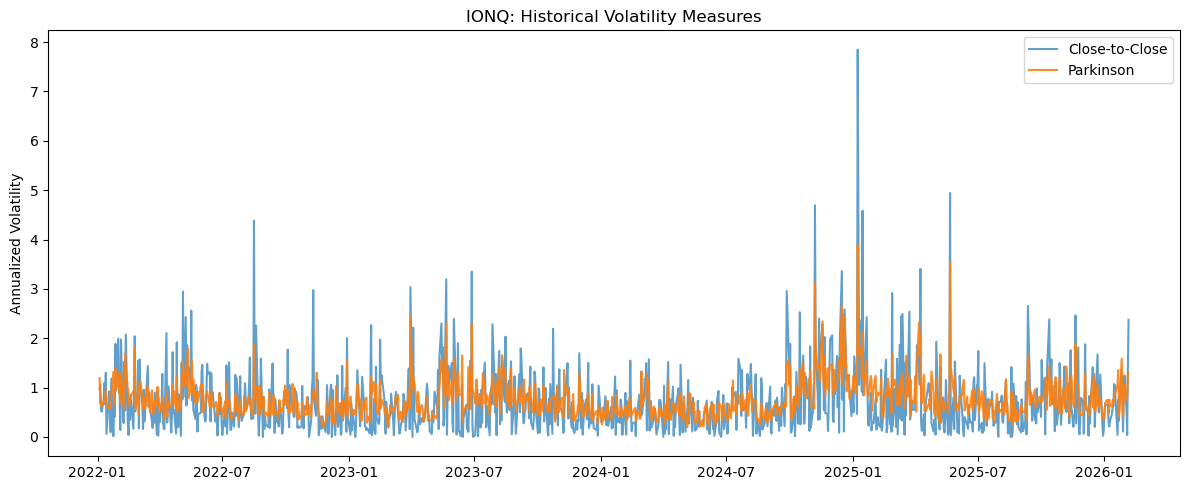

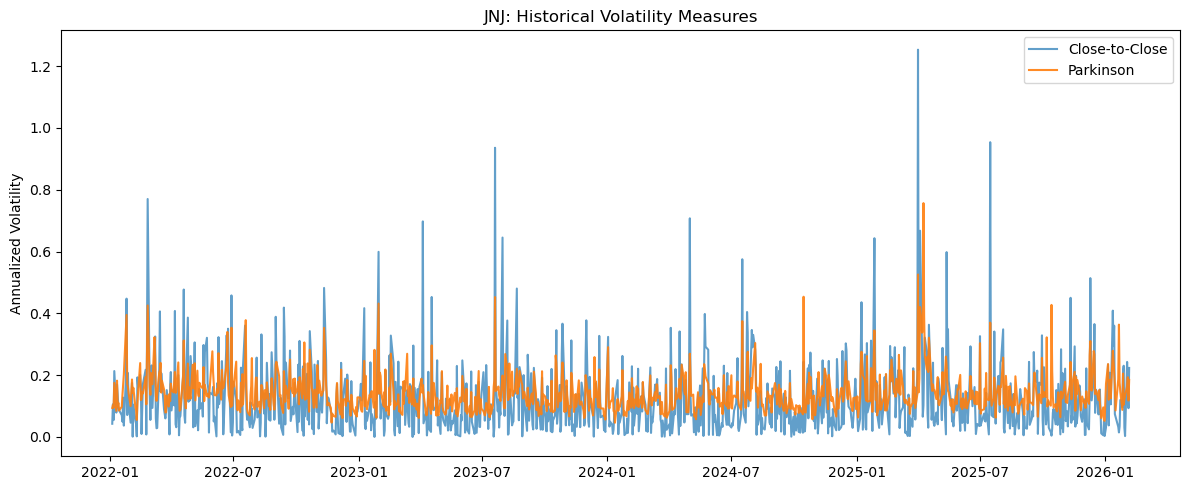

In [574]:
plt.figure(figsize=(12, 5))

plt.plot(vol[tickers[0]].index, vol[tickers[0]]["CtC"], label="Close-to-Close", alpha=0.7)
plt.plot(vol[tickers[0]].index, vol[tickers[0]]["Parkinson"], label="Parkinson", alpha=0.9)

plt.title(f"{tickers[0]}: Historical Volatility Measures")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.plot(vol[tickers[1]].index, vol[tickers[1]]["CtC"], label="Close-to-Close", alpha=0.7)
plt.plot(vol[tickers[1]].index, vol[tickers[1]]["Parkinson"], label="Parkinson", alpha=0.9)

plt.title(f"{tickers[1]}: Historical Volatility Measures")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.tight_layout()
plt.show()

In [572]:
def vol_stats(x):
    return pd.Series({
        "mean": x.mean(),
        "median": x.median(),
        "std": x.std(),
        "min": x.min(),
        "25%": x.quantile(0.25),
        "75%": x.quantile(0.75),
        "max": x.max()
    })

stats = {}

for t in tickers:
    stats[(t, "CtC")] = vol_stats(vol[t]["CtC"])
    stats[(t, "Parkinson")] = vol_stats(vol[t]["Parkinson"])

stats_df = pd.DataFrame(stats).T
stats_df.index = pd.MultiIndex.from_tuples(stats_df.index, names=["Stock", "Estimator"])

print(stats_df)


                     mean    median       std       min       25%       75%  \
Stock Estimator                                                               
IONQ  CtC        0.719876  0.557547  0.672554  0.000000  0.263486  0.983146   
      Parkinson  0.760162  0.678647  0.377337  0.185525  0.508766  0.904049   
JNJ   CtC        0.124342  0.090499  0.119799  0.000000  0.041195  0.172737   
      Parkinson  0.142568  0.128979  0.064610  0.045880  0.099949  0.167708   

                      max  
Stock Estimator            
IONQ  CtC        7.846658  
      Parkinson  3.893456  
JNJ   CtC        1.253337  
      Parkinson  0.756771  


The two stocks display markedly different volatility profiles. IONQ exhibits substantially higher volatility than JNJ under both estimators, reflecting its status as a smaller, growth-oriented stock with greater uncertainty and sensitivity to news. In contrast, JNJ shows consistently low volatility, consistent with a large, mature firm with stable cash flows. These differences are clear both visually in the volatility plots and in the descriptive statistics, where IONQ shows much higher means, medians, standard deviations, and extreme maximum values, while JNJ’s volatility is lower, more stable, and tightly distributed.

Across both stocks, the Parkinson estimator generally produces smoother and slightly lower variability than the close-to-close measure. This is especially evident for IONQ, where close-to-close volatility displays sharp spikes that are less pronounced under the Parkinson measure. This occurs because close-to-close volatility is more sensitive to overnight price jumps, while the Parkinson estimator relies on intraday high–low information and filters out some of this noise. From an investor’s standpoint, these results highlight the importance of both stock selection and volatility measurement: IONQ’s high and variable volatility calls for careful position sizing and risk controls, while JNJ’s lower volatility makes it more suitable for defensive or income-oriented portfolios.

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


Problem C2.


Download daily closing price data for any two market indices from (Yahoo Finance). Your sample must contain
at least 252 daily observations per index (about one trading year); there is no upper limit on the sample length.
Please note that your dataset should remain confidential.
(a) Log returns: Compute daily log returns for each index:
rt = 100 · ln
 Pt
Pt−1

,
3
where Pt denotes the daily closing price.
(b) GARCH estimation: For each return series, estimate two volatility models selected from the following list:
• GARCH(1, 1),
• GJR-GARCH(1, 1),
• EGARCH(1, 1).
Assume a constant mean for returns, i.e., rt = μ + εt.
(c) Model selection. For each index, identify the preferred model. Explain.
(d) Comparison and interpretation: Compare the estimated parameters and volatility dynamics:
• Within each index: compare the two fitted models (e.g., ω, α, β and any asymmetry term; persistence such
as α + β when applicable).
• Across indices: compare volatility persistence and (if applicable) asymmetry/leverage effects.
(e) Diagnostics (required): Provide at least one residual diagnostic for each fitted model (e.g., Ljung–Box test
or ACF plots for standardized residuals and squared standardized residuals).

In [485]:
IDX1 = "^RUT"
IDX2 = "^DJI"

data = yf.download([IDX1, IDX2], start="2018-01-01", progress=False)["Close"].dropna()
data.columns = [IDX1, IDX2]

print(data.shape)
print(data.head())


(2034, 2)
                    ^RUT         ^DJI
Date                                 
2018-01-02  24824.009766  1550.010010
2018-01-03  24922.679688  1552.579956
2018-01-04  25075.130859  1555.719971
2018-01-05  25295.869141  1560.010010
2018-01-08  25283.000000  1561.810059


In [493]:
ret = 100 * np.log(data / data.shift(1)).dropna()
ret.columns = ["r1", "r2"]

r1 = ret["r1"]
r2 = ret["r2"]

print(ret.describe())


                r1           r2
count  2033.000000  2033.000000
mean      0.033949     0.025905
std       1.202281     1.581357
min     -13.841812   -15.399089
25%      -0.450313    -0.761173
50%       0.076399     0.075884
75%       0.593990     0.890314
max      10.764328     8.976265


In [499]:
def fit_models(series):
    series = series.dropna()

    # Constant mean: r_t = mu + eps_t (default mean='Constant')
    m_garch = arch_model(series, mean="Constant", vol="GARCH", p=1, q=1, dist="normal")
    res_garch = m_garch.fit(disp="off")

    m_egarch = arch_model(series, mean="Constant", vol="EGARCH", p=1, q=1, dist="normal")
    res_egarch = m_egarch.fit(disp="off")

    # Optional: GJR-GARCH(1,1): o=1 adds the asymmetry term
    m_gjr = arch_model(series, mean="Constant", vol="GARCH", p=1, o=1, q=1, dist="normal")
    res_gjr = m_gjr.fit(disp="off")

    return res_garch, res_egarch, res_gjr

r1_garch, r1_egarch, r1_gjr = fit_models(r1)
r2_garch, r2_egarch, r2_gjr = fit_models(r2)


In [517]:
#Claude wrote these to help compare model summaries
def model_summary_row(res, name):
    return pd.Series({
        "Model": name,
        "LogLik": res.loglikelihood,
        "AIC": res.aic,
        "BIC": res.bic,
        "mu": res.params.get("mu", np.nan),
        "omega": res.params.get("omega", np.nan),
        "alpha1": res.params.get("alpha[1]", np.nan),
        "beta1": res.params.get("beta[1]", np.nan),
        "gamma1": res.params.get("gamma[1]", np.nan),
        "p_mu": res.pvalues.get("mu", np.nan),
        "p_omega": res.pvalues.get("omega", np.nan),
        "p_alpha1": res.pvalues.get("alpha[1]", np.nan),
        "p_beta1": res.pvalues.get("beta[1]", np.nan),
        "p_gamma1": res.pvalues.get("gamma[1]", np.nan),
    })

def compare_two(resA, nameA, resB, nameB):
    df = pd.DataFrame([
        model_summary_row(resA, nameA),
        model_summary_row(resB, nameB)
    ])
    return df.set_index("Model")

def pick_preferred(tbl):
    # pick by BIC (or AIC)
    return tbl["BIC"].idxmin()

def garch_persistence(res):
    a = res.params.get("alpha[1]", np.nan)
    b = res.params.get("beta[1]", np.nan)
    return a + b

def gjr_effective_persistence(res):
    a = res.params.get("alpha[1]", np.nan)
    b = res.params.get("beta[1]", np.nan)
    g = res.params.get("gamma[1]", 0.0)
    # common approximation under symmetry of shocks:
    return a + b + 0.5*g

def ljung_box_diagnostics(res, lags=20):
    z = res.std_resid.dropna()           # standardized residuals
    z2 = (z**2).dropna()

    lb_z = acorr_ljungbox(z, lags=[lags], return_df=True)
    lb_z2 = acorr_ljungbox(z2, lags=[lags], return_df=True)

    out = pd.DataFrame({
        "LB stat (z)": lb_z["lb_stat"],
        "LB pvalue (z)": lb_z["lb_pvalue"],
        "LB stat (z^2)": lb_z2["lb_stat"],
        "LB pvalue (z^2)": lb_z2["lb_pvalue"],
    })
    return out





In [521]:
tbl_r1 = compare_two(r1_garch, "GARCH(1,1)", r1_egarch, "EGARCH(1,1)")
tbl_r2 = compare_two(r2_garch, "GARCH(1,1)", r2_egarch, "EGARCH(1,1)")

print("\nIndex 1 comparison:")
print(tbl_r1)

print("\nIndex 2 comparison:")
print(tbl_r2)

print("\n\nPreferred (Index1) by BIC:", pick_preferred(tbl_r1))
print("Preferred (Index2) by BIC:", pick_preferred(tbl_r2))

print("\n\nIndex1 GARCH alpha+beta:", garch_persistence(r1_garch))
print("Index2 GARCH alpha+beta:", garch_persistence(r2_garch))

print("\n\nIndex1 GJR effective persistence:", gjr_effective_persistence(r1_gjr))
print("Index2 GJR effective persistence:", gjr_effective_persistence(r2_gjr))

print("\n\nIndex1 GARCH diagnostics:\n", ljung_box_diagnostics(r1_garch))
print("Index1 EGARCH diagnostics:\n", ljung_box_diagnostics(r1_egarch))

print("\n\nIndex2 GARCH diagnostics:\n", ljung_box_diagnostics(r2_garch))
print("Index2 EGARCH diagnostics:\n", ljung_box_diagnostics(r2_egarch))



Index 1 comparison:
                  LogLik          AIC          BIC        mu     omega  \
Model                                                                    
GARCH(1,1)  -2713.731296  5435.462592  5457.931663  0.066695  0.053031   
EGARCH(1,1) -2723.908555  5455.817110  5478.286182  0.078537  0.008593   

               alpha1     beta1  gamma1      p_mu   p_omega      p_alpha1  \
Model                                                                       
GARCH(1,1)   0.167612  0.786647     NaN  0.000117  0.000104  5.832428e-09   
EGARCH(1,1)  0.345159  0.945405     NaN  0.000005  0.316360  4.865601e-13   

                   p_beta1  p_gamma1  
Model                                 
GARCH(1,1)   2.336302e-132       NaN  
EGARCH(1,1)   0.000000e+00       NaN  

Index 2 comparison:
                  LogLik          AIC          BIC        mu     omega  \
Model                                                                    
GARCH(1,1)  -3501.400132  7010.800265  7033.2693

For both indices, GARCH(1,1) is preferred by BIC (Index 1: 5457.93 vs 5478.29; Index 2: 7033.27 vs 7035.28). AIC also favors GARCH in both cases. Since GARCH is the more parsimonious model and already fits well, the criteria point to GARCH(1,1) as the better choice for each index.


Within each index, both the GARCH(1,1) and EGARCH(1,1) models indicate highly persistent volatility dynamics. For Index 1, the GARCH model yields a persistence measure of approximately 0.95, while the EGARCH specification implies similarly strong persistence, though its constant term is not statistically significant. This suggests that the additional flexibility of EGARCH does not meaningfully improve the model relative to the simpler GARCH specification. Although EGARCH captures volatility dynamics slightly differently, information criteria favor GARCH for both indices, indicating that the added complexity of EGARCH is not justified. Comparing across indices, Index 2 exhibits very simmilar volatility persistance as Index 1, implying that shocks to volatility decay more slowly and high-volatility periods tend to last longer. While both indices display the strong persistence typical of equity markets, the results do not provide clear evidence of leverage or asymmetry effects, as no meaningful asymmetry term is identified in the EGARCH outputs.


Residual diagnostics support the adequacy of the fitted volatility models for both indices. Ljung–Box tests applied to standardized residuals and squared standardized residuals at lag 20 yield high p-values across all models, meaning the null hypothesis of no residual autocorrelation cannot be rejected. This indicates that the models successfully capture both linear dependence and conditional heteroskedasticity in the return series.